## 使用卷积神经网络对CIFAR-10数据集进行分类

In [51]:
import os
import pickle as p
import tarfile
import urllib.request
from time import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

## 准备数据集

In [52]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
filepath = "Data/CIFAR-10/cifar-10-python.tar.gz"

# 下载数据集
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url, filepath)
    print("downloaded: ", result)
else:
    print("Data file already exists")

# 解压数据集
if not os.path.exists("Data/CIFAR-10/DataSets"):
    tfile = tarfile.open("Data/CIFAR-10/cifar-10-python.tar.gz", "r:gz")
    result = tfile.extractall("Data/CIFAR-10/DataSets")
    print("Extract to Data/CIFAR-10/DataSets")
else:
    print("Data file already exists")

Data file already exists
Data file already exists


## 导入数据集

In [53]:
# 按批次导入
def load_CIFAR_batch(filename):
    with open(filename, "rb") as f:
        data_dict = p.load(f, encoding="bytes")
        images = data_dict[b"data"]
        labels = data_dict[b"labels"]

        # 将原始数据调整为BCWH
        images = images.reshape(10000, 3, 32, 32)
        # tensorflow处理图象数据的结构：BWHC
        # 把通道数数据C移动到最后一个维度
        images = images.transpose(0, 2, 3, 1)

        labels = np.array(labels)

        return images, labels

In [54]:
# 导入数据集
def load_CIFAR_data(data_dir):
    images_train = []
    labels_train = []

    for i in range(5):
        f = os.path.join(data_dir, "data_batch_%d" % (i + 1))
        print("loading", f)

        # 调用load_CIFAR_batch()获得批量的图像机器对应的标签
        image_batch, label_batch = load_CIFAR_batch(f)

        images_train.append(image_batch)
        labels_train.append(label_batch)

        Xtrain = np.concatenate(images_train)
        Ytrain = np.concatenate(labels_train)

        del image_batch, label_batch

    Xtest, Ytest = load_CIFAR_batch(os.path.join(data_dir, "test_batch"))
    print("Finished loading CIFAR-10 data")

    # 返回训练集的体香和标签，测试集的图像和标签
    return Xtrain, Ytrain, Xtest, Ytest


data_dir = "Data/CIFAR-10/DataSets/cifar-10-batches-py"
Xtrain, Ytrain, Xtest, Ytest = load_CIFAR_data(data_dir)

loading Data/CIFAR-10/DataSets/cifar-10-batches-py\data_batch_1
loading Data/CIFAR-10/DataSets/cifar-10-batches-py\data_batch_2
loading Data/CIFAR-10/DataSets/cifar-10-batches-py\data_batch_3
loading Data/CIFAR-10/DataSets/cifar-10-batches-py\data_batch_4
loading Data/CIFAR-10/DataSets/cifar-10-batches-py\data_batch_5
Finished loading CIFAR-10 data


## 查看数据集

In [55]:
print("Training data shape: ", Xtrain.shape)
print("Training labels shape: ", Ytrain.shape)
print("Test im shape: ", Xtest.shape)
print("Test labels shape: ", Ytest.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test im shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


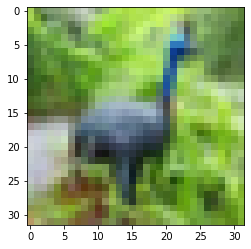

In [56]:
# 查看单项数据
plt.imshow(Xtrain[6])

In [57]:
print(Ytrain[6])

2


## 定义多项images与label

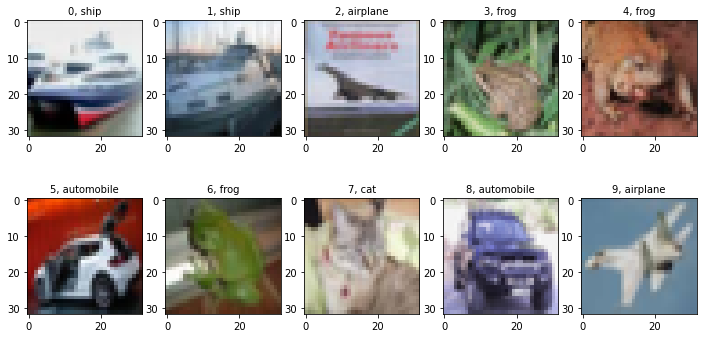

In [58]:
# 定义标签字典，每一个数字所代表的图像类别的名称
label_dict = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse",
              8: "ship", 9: "truck"}


# 定义显示图像数据及其对应标签的函数
def plot_images_labels_prediction(images, labels, prediction, idx, num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 6)

    if num > 10:
        num = 10

    for i in range(0, num):
        ax = plt.subplot(2, 5, 1 + i)
        ax.imshow(images[idx], cmap="binary")

        title = str(i) + ", " + label_dict[labels[idx]]
        if len(prediction) > 0:
            title += "=>" + label_dict[prediction[idx]]

        ax.set_title(title, fontsize=10)

        idx += 1

    plt.show()


plot_images_labels_prediction(Xtest, Ytest, [], 1, 10)

## 数据预处理

In [59]:
# 查看图像数据信息
# 显示第一个图的第一个像素点
Xtrain[0][0][0]

array([59, 62, 63], dtype=uint8)

In [60]:
# 将图像进行数字标准化
Xtrain_normalize = Xtrain.astype("float32") / 255.0
Xtest_normalize = Xtest.astype("float32") / 255.0

In [61]:
# 查看预处理后的图像数据信息
Xtrain_normalize[0][0][0]

array([0.23137255, 0.24313726, 0.24705882], dtype=float32)

## 标签数据预处理 - 独热编码

In [62]:
# 查看标签数据
Ytrain[:10]

array([6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [63]:
encoder = OneHotEncoder(sparse=False)

yy = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]

encoder.fit(yy)

Ytrain_reshape = Ytrain.reshape(-1, 1)
Ytrain_onehot = encoder.transform(Ytrain_reshape)
Ytest_reshape = Ytest.reshape(-1, 1)
Ytest_onehot = encoder.transform(Ytest_reshape)

In [64]:
Ytrain_onehot.shape

(50000, 10)

In [65]:
Ytrain_onehot[:5]

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

## 定义共享函数

In [66]:
# 定义权值
def weight(shape):
    # 在构建模型时，需要使用tfVariable来创建一个变量
    # 在训练时，这个变量不断更新
    # 使用函数tf.truncated.normal（截断的正态分布）生成标准差为0.1的随机数来初始化权值
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name="W")


# 定义偏置
# 初始化0.1
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape), name="b")


# 定义卷积操作
# 步长为1，padding为"SAME"
def conv2d(x, W):
    # tf.nn.conv2d(input, filter, strides, padding, use_cudnn_oon_gpu=None, name=None)
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")


# 定义池化操作
# 步长为2，即原尺寸的长和宽各除以2
def max_pool_2x2(x):
    # tf.nn.max_pool(value, ksize, strides, padding, name=None)
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

## 定义网络结构

+ 图像的特征提取：通过卷积层1，降采样层1，卷积层2以及降采样层的处理，提取图像的特征
+ 全连接神经网路：全连接层、输出层所组成的网络结构

| 输入层                | 卷积层1                                    | 降采样层1                                      | 卷积层2                                     | 降采样层2                                    | 全连接层                                 | 输出层                      |
|--------------------|-----------------------------------------|--------------------------------------------|------------------------------------------|------------------------------------------|--------------------------------------|--------------------------|
|  32*32图像，通道为3（RGB） | 第1次卷积：输入通道：3，输出通道：32，卷积后图像尺寸不变，依然是32*32 | 第一次降采样：将32*32图像缩小为16*16；池化不改变通道数量，因此依然是32个 | 第2次卷积：输入通道：32，输出通道：64，卷积后图像尺寸不变，依然是16*16 | 第二次降采样：将16*16图像缩小为8*8；池化不改变通道数量，因此依然是64个 | 将64个8*8的图像转换为长度为4096的一维向量，该层有128个神经元 | 输出层共有10个神经元，对应到0-9这10个类别 |

In [67]:
# 输入层
# 32*32图像，通道为3（RGB）
with tf.name_scope("input_layer"):
    x = tf.placeholder("float", shape=[None, 32, 32, 3], name="X")

In [68]:
# 第1个卷积层
# 输入通道：3，输出通道：32，卷积后图像尺寸不变，依然是32*32
with tf.name_scope("conv_1"):
    # [k_width, k_height, input_chn, output_chn]
    W1 = weight([3, 3, 3, 32])
    b1 = bias([32])
    conv_1 = conv2d(x, W1) + b1
    conv_1 = tf.nn.relu(conv_1)

# 第1个池化层
# 将32*32图像缩小为16*16，池化不改变通道数量，因此依然是32个
with tf.name_scope("pool_1"):
    pool_1 = max_pool_2x2(conv_1)

# 第2个卷积层
# 输入通道：32，输出通道：64，卷积后图像尺寸不变，依然是16*16
with tf.name_scope("conv_2"):
    W2 = weight([3, 3, 32, 64])
    b2 = bias([64])
    conv_2 = conv2d(pool_1, W2) + b2
    conv_2 = tf.nn.relu(conv_2)

# 第2个池化层
# 将16*16图像缩小为8*8，池化不改变通道数量，因此以此是64个
with tf.name_scope("pool_2"):
    pool_2 = max_pool_2x2(conv_2)

# 全连接层
# 将第2个池化层的64个8*8的图像转换为一维的向量，长度是64*8*8=4096
with tf.name_scope("fc"):
    W3 = weight([4096, 128])
    b3 = bias([128])
    flat = tf.reshape(pool_2, [-1, 4096])
    h = tf.nn.relu(tf.matmul(flat, W3) + b3)
    h_dropout = tf.nn.dropout(h, keep_prob=0.8)


In [69]:
# 输出层
# 输出层共有10个神经元，对应到0~9这10个类别
with tf.name_scope("output_layer"):
    W4 = weight([128, 10])
    b4 = bias([10])
    pred = tf.nn.softmax(tf.matmul(h_dropout, W4) + b4)

## 构建模型

In [70]:
with tf.name_scope("optimizer"):
    # 定义占位符
    y = tf.placeholder("float", shape=[None, 10], name="label")

    # 定义损失函数
    loss_function = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

    # 选择优化器
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_function)

## 定义准确率

In [71]:
with tf.name_scope("evaluation"):
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

## 定义模型参数

In [72]:
train_epochs = 25
batch_size = 50
total_batch = int(len(Xtrain) / batch_size)

## 启动会话

In [73]:
epoch_list = []
accuracy_list = []
loss_list = []
epoch = tf.Variable(0, name="epoch", trainable=False)

startTime = time()

session = tf.Session()
init = tf.global_variables_initializer()
session.run(init)

## 断点续训

In [74]:
# 设置检查点存储目录
ckpt_dir = "Model_ckpt/8-CIFAR/"

if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

# 生成saver
saver = tf.train.Saver(max_to_keep=1)

# 如果有检查点文件，读取最新的检查点文件，恢复各种变量值
ckpt = tf.train.latest_checkpoint(ckpt_dir)
if ckpt != None:
    # 恢复所有参数
    saver.restore(session, ckpt)
else:
    # 从恢复点使用模型预测，或接着训练
    print("Training from scratch")

# 获取续训参数
start = session.run(epoch)
print("Training starts from {} epoch".format(start + 1))

Training from scratch
Training starts from 1 epoch


## 迭代训练

改进方式（根据个人可利用的计算资源）

+ 增加网络层数
+ 增加迭代次数
+ 增加全连接层数
+ 增加全连接层的神经元个数
+ 数据扩增
+ ...

In [75]:
def get_train_batch(number, batch_size):
    return Xtrain_normalize[number *
                            batch_size:(number + 1) * batch_size], Ytrain_onehot[number *
                                                                                 batch_size:(number + 1) * batch_size]


for ep in range(start, train_epochs):
    for i in range(total_batch):
        batch_x, batch_y = get_train_batch(i, batch_size)
        session.run(optimizer, feed_dict={x: batch_x, y: batch_y})

        if i % 100 == 0:
            print("Step: {}".format(i), "Finish")

    loss, acc = session.run([loss_function, accuracy], feed_dict={x: batch_x, y: batch_y})

    epoch_list.append(ep + 1)
    loss_list.append(loss)
    accuracy_list.append(acc)

    print("Train epoch:", "%02d" % (session.run(epoch) + 1),
          "Loss=", "{:.6f}".format(loss),
          "Accuracy=", acc)

    # 保存检查点
    saver.save(session, ckpt_dir + "CIFAR10_cnn_model.ckpt", global_step=ep + 1)
    session.run(epoch.assign(ep + 1))

duration = time() - startTime
print("Train finished takes: ", duration)

Step: 0 Finish
Step: 100 Finish
Step: 200 Finish
Step: 300 Finish
Step: 400 Finish
Step: 500 Finish
Step: 600 Finish
Step: 700 Finish
Step: 800 Finish
Step: 900 Finish
Train epoch: 01 Loss= 2.218248 Accuracy= 0.24
Step: 0 Finish
Step: 100 Finish
Step: 200 Finish
Step: 300 Finish
Step: 400 Finish
Step: 500 Finish
Step: 600 Finish
Step: 700 Finish
Step: 800 Finish
Step: 900 Finish
Train epoch: 02 Loss= 2.136147 Accuracy= 0.38
Step: 0 Finish
Step: 100 Finish
Step: 200 Finish
Step: 300 Finish
Step: 400 Finish
Step: 500 Finish
Step: 600 Finish
Step: 700 Finish
Step: 800 Finish
Step: 900 Finish
Train epoch: 03 Loss= 2.124821 Accuracy= 0.34
Step: 0 Finish
Step: 100 Finish
Step: 200 Finish
Step: 300 Finish
Step: 400 Finish
Step: 500 Finish
Step: 600 Finish
Step: 700 Finish
Step: 800 Finish
Step: 900 Finish
Train epoch: 04 Loss= 2.149383 Accuracy= 0.3
Step: 0 Finish
Step: 100 Finish
Step: 200 Finish
Step: 300 Finish
Step: 400 Finish
Step: 500 Finish
Step: 600 Finish
Step: 700 Finish
Step: 800 F

## 可视化损失值

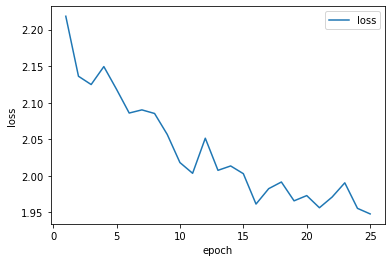

In [77]:
flg = plt.gcf()
# flg.set_size_inches(4,2)
plt.plot(epoch_list, loss_list, label="loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss"], loc="upper right")

## 可视化准确率

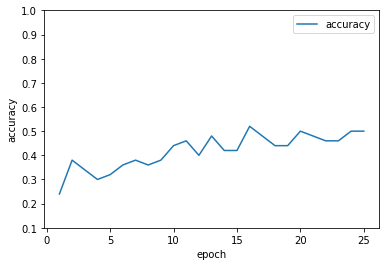

In [80]:
plt.plot(epoch_list, accuracy_list, label="accuracy")
fig = plt.gcf()
plt.ylim(0.1, 1)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## 评估模型

In [83]:
test_total_batch = int(len(Xtest_normalize) / batch_size)
test_acc_sum = 0.0

for i in range(test_total_batch):
    test_image_batch = Xtest_normalize[i * batch_size:(i + 1) * batch_size]
    test_label_batch = Ytest_onehot[i * batch_size:(i + 1) * batch_size]
    test_batch_acc = session.run(accuracy, feed_dict={x: test_image_batch, y: test_label_batch})
    test_acc_sum += test_batch_acc

test_acc = float(test_acc_sum / test_total_batch)
print("Test accuracy: {:.6f}".format(test_acc))

Test accuracy: 0.595800


## 利用模型进行预测

In [85]:
test_pred = session.run(pred, feed_dict={x: Xtest_normalize[:10]})
prediction_result = session.run(tf.argmax(test_pred, 1))

## 可视化预测结果

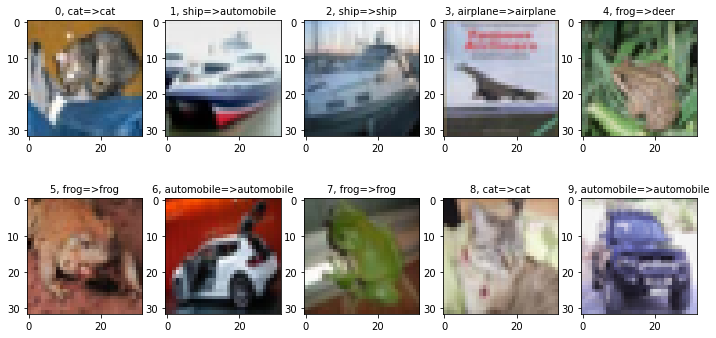

In [86]:
plot_images_labels_prediction(Xtest, Ytest, prediction_result, 0, 10)